# Online Gradient Computation in JAX

`models` implements a range of neural network models in JAX.

`OnlineCTRNNCell` implements a CT-RNN with custom gradients for RTRL or RFLO. 

The `FADense` module can be configured to use feedback alignment. 

In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import numpy as np
from models import FADense
import jax
from jax import numpy as jnp
import jax.random as jrand
import optax

import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We create a sinusoidal function as a toy dataset. Lets also initialize the model and plot the initial predictions.

In [3]:
key = jrand.PRNGKey(0)
key, key_model, key_data, key_train = jrand.split(key, 4)
x = np.linspace(0, 10*np.pi, 1000)[:, None]
y = np.sin(x) + 2

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


(1, 1)


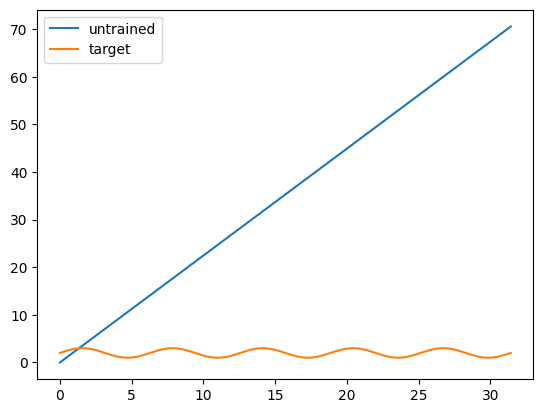

In [4]:
model = FADense(x.shape[-1])
params = model.init(key_model, x)
print(params["params"]["kernel"].shape)
untrained_output = model.apply(params, x).squeeze()

plt.plot(x, untrained_output, label='untrained')
plt.plot(x, y, label='target')
plt.legend()

Next, we define a loss function and compute the loss of the untrained model.

In [5]:
def loss_fn(_params, __x, __y):
    # MSE loss
    y_hat = model.apply(_params,__x)
    return jnp.mean((y_hat - __y)**2)

loss_fn(params, x, y)

Array(1529.4653, dtype=float32)

Now we can train the model and plot the result.

In [6]:
def print_progress(i, loss):
    if i % 1000 == 0:
        print(f'Iteration {i} | Loss: {loss:.3f}')

def train(params, data, key, num_steps=10_000, lr=1e-2, batch_size=256):
    # We use Stochastic Gradient Descent with a constant learning rate
    _x, _y = data
    optimizer = optax.adam(lr)
    opt_state = optimizer.init(params)
    def step(carry, n):
        _params, _opt_state, _key = carry
        _key, key_batch = jrand.split(_key)
        batch = jrand.choice(key_batch, np.hstack([_x, _y]), (batch_size,))
        current_loss, grads = jax.value_and_grad(loss_fn)(_params, batch[:,:1], batch[:,1:2])
        updates, _opt_state = optimizer.update(grads, _opt_state, _params)
        _params = optax.apply_updates(_params, updates)
        jax.debug.callback(print_progress, n, current_loss)
        return (_params, _opt_state, _key), current_loss
    (params, *_), losses = jax.lax.scan(step, (params, opt_state, key), np.arange(num_steps, dtype=np.int32))
    print(f'Final loss: {losses[-1]:.3f}')
    return params, losses


Iteration 0 | Loss: 1573.043
Iteration 1000 | Loss: 4.075
Iteration 2000 | Loss: 1.751
Iteration 3000 | Loss: 0.738
Iteration 4000 | Loss: 0.553
Iteration 5000 | Loss: 0.471
Iteration 6000 | Loss: 0.505
Iteration 7000 | Loss: 0.486
Iteration 8000 | Loss: 0.473
Iteration 9000 | Loss: 0.470
Final loss: 0.510


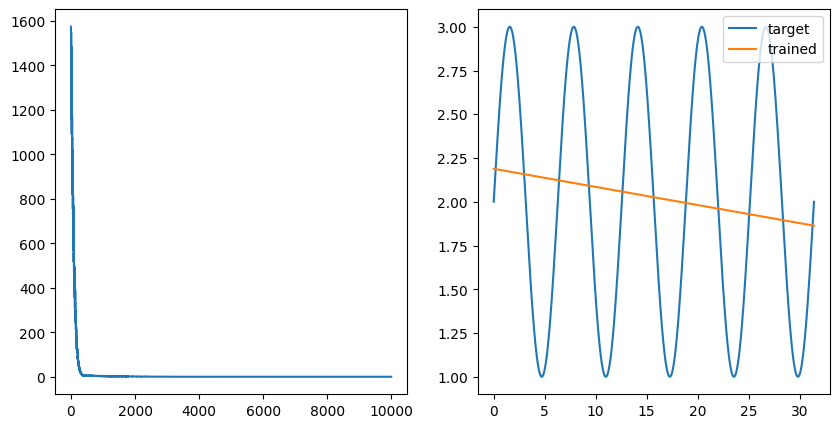

In [7]:
key, key_train = jrand.split(key_data)
params, losses = train(params, (x, y), key)

plt.figure(figsize=(10, 5))

# Plot the training loss
plt.subplot(1, 2, 1)
plt.plot(losses)

# Plot the trained model output
plt.subplot(1, 2, 2)
y_hat = model.apply(params, x)
plt.plot(x, y, label='target')
plt.plot(x, y_hat, label='trained')
plt.legend()

Since the model is Linear it cannot fit the sinusoidal function. Let's instead use a RNN with a single hidden layer.

In [8]:
from flax import linen as nn
from models import OnlineCTRNNCell
from supervised.training_utils import train_rnn_online
from supervised.training_utils import predict

class Model(nn.Module):
    
    @nn.nowrap
    def make_rnn(self):
        return OnlineCTRNNCell(64, name="rnn")
    
    @nn.nowrap
    def __getattr__(self, name):
        return self.make_rnn().__getattribute__(name)
    
    @staticmethod
    def clip_tau(params):
        params["rnn"] = OnlineCTRNNCell.clip_tau(params["rnn"])
        return params
    
    @nn.compact
    def __call__(self, _x, carry):
        carry, _x = self.make_rnn()(_x, carry)
        _x = FADense(x.shape[-1])(_x)
        return carry, _x


model = Model()
state = model.initialize_carry(key_model, x[0].shape)
params = model.init(key_model, state, x[0])

def loss_fn(_params, __x, __y, carry):
    # MSE loss
    carry, y_hat = model.apply(_params, carry, __x)
    return jnp.mean((y_hat - __y)**2), carry

Train the model

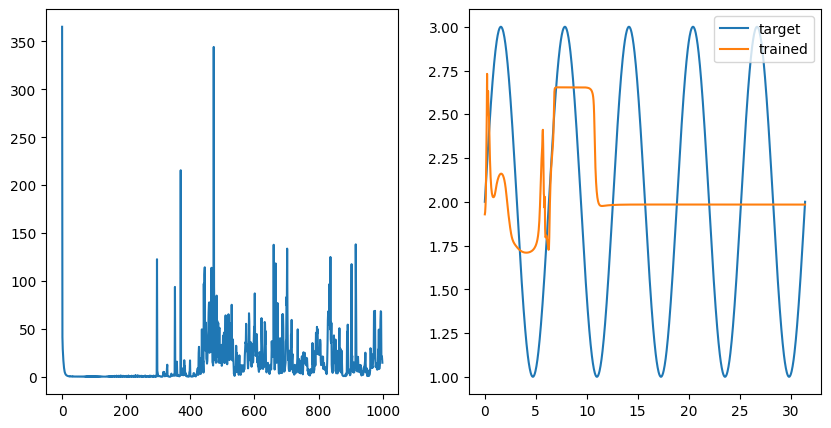

In [18]:
key, key_train = jrand.split(key_data)
params, losses = train_rnn_online(loss_fn, params, (x, y), key_train, state, num_steps=1e3, param_post_update_fn=model.clip_tau)


plt.figure(figsize=(10, 5))

# Plot the training loss
plt.subplot(1, 2, 1)
plt.plot(losses)

# Plot the trained model output
plt.subplot(1, 2, 2)
y_hat = predict(model, params, x)
plt.plot(x, y, label='target')
plt.plot(x, y_hat, label='trained')
plt.legend()

## Two spirals dataset

In [48]:
from experiments.supervised.datasets import Spirals
import numpy as np

x, y = Spirals(4, key=key_data)
print(x.shape, y.shape)
def plot_spirals(x, y):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    for t in range(x.shape[1]):
        ax.scatter(t, x[:, t, 0], x[:, t, 1], c=y)
plot_spirals(x, y)

ModuleNotFoundError: No module named 'experiments'

Let's see how our model performs on the more complex dataset.

In [18]:
model = Linear(np.prod(x.shape[-2:]), y.shape[-1], key=key_model, use_bias=True)
flat_x = x.reshape(x.shape[0], -1)
untrained_output = jax.vmap(model)(flat_x).squeeze()
model, losses = train(model, (flat_x, y), num_steps=1000, key=key_train)
trained_output = jax.vmap(model)(flat_x).squeeze()
plot_spirals(x, trained_output)

TypeError: dot_general requires contracting dimensions to have the same shape, got (32,) and (1,).